Data Source: https://www.kaggle.com/datasets/adityajn105/flickr8k

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from nltk.corpus import stopwords
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as tarnform
import spacy
import re
import torchvision.transforms as T

In [2]:
data_location = '../input/flickr8k/'
df = pd.read_csv("../input/flickr8k/captions.txt")
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from nltk.corpus import stopwords
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as tarnform
import spacy
import re
import torchvision.transforms as T
from PIL import Image

../input/flickr8k//Images/1012212859_01547e3f17.jpg


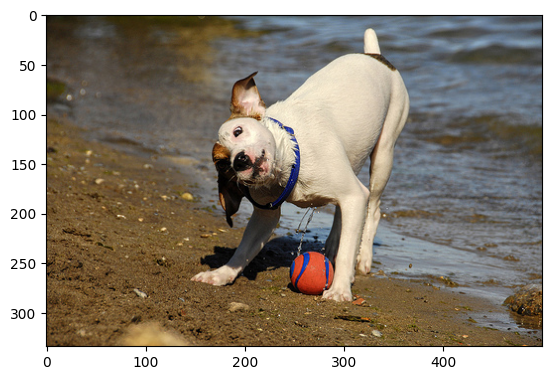

In [4]:
data_idx = 36
image_path = data_location+"/Images/"+df.iloc[data_idx,0]
print(image_path)

img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

In [5]:
spacy_eng = spacy.load('en_core_web_sm')
text = 'This is a good place for study'
[token.text.lower() for token in spacy_eng.tokenizer(text)]
for token in spacy_eng(text):
    print(token)

This
is
a
good
place
for
study


In [6]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def show_image(inp, title = None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [7]:
def tokenizer(text):
    word_list = []
    for word in text.lower().split():
        word = preprocess_string(word)
        word_list.append(word)
    return word_list

In [8]:
from collections import Counter

class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        return tokenize(text)

    def build_vocab(self, sentence_list):
        freq = Counter()
        idx = len(self.itos)

        # Count frequency of each word
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                freq[word] += 1

        # Add words to the vocabulary
        for word, count in freq.items():
            if count >= self.freq_threshold:  # Add to vocab if frequency exceeds threshold
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalized(self, text):
        tokenized_text = self.tokenize(text)
        numericalized_text = []

        # Convert words to indices
        for token in tokenized_text:
            numericalized_text.append(self.stoi.get(token, self.stoi["<UNK>"])) 

        return numericalized_text


In [16]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.df = self.df.head(1024)
        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
    def __len__(self):
        return len(self.df)


    # def __getitem__(self, idx):
    #     caption = self.captions[idx]
    #     img_name = self.imgs[idx]
    #     img_location = os.path.join(self.root_dir,img_name)
    #     img = Image.open(img_location).convert("RGB")
    #     caption_vec = []
    #     caption_vec += [self.vocab.stoi["<SOS>"]]
    #     caption_vec += self.vocab.numericalize(caption)
    #     caption_vec += [self.vocab.stoi["<EOS>"]]
    #     return img, torch.tensor(caption_vec)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir, img_name)
        
        # Open the image
        img = Image.open(img_location).convert("RGB")
    
        # Apply transformations
        if self.transform:
            img = self.transform(img)
    
        caption_vec = [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalized(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        return img, torch.tensor(caption_vec)

========>>
----- tensor([ 1,  4, 24,  3, 88, 89, 87, 20, 90, 91,  4, 75, 92, 62, 21, 49, 14,  2])


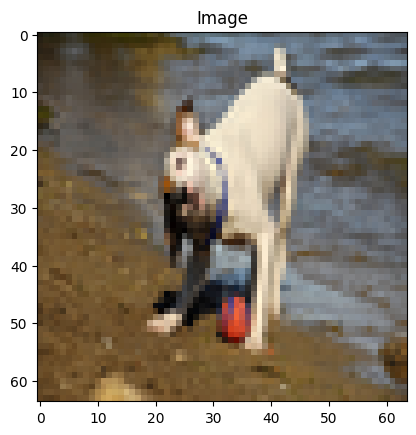

Token: tensor([ 1,  4, 24,  3, 88, 89, 87, 20, 90, 91,  4, 75, 92, 62, 21, 49, 14,  2])
Sentence:


In [17]:
transforms = T.Compose([
    T.Resize((64, 64), interpolation=Image.LANCZOS),
    T.ToTensor()
])
print('========>>')
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)
img, caps = dataset[35]
print("-----", caps)
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
# for token in caps.tolist():
#     result.append(dataset.vocab.itos[token])


In [18]:
class CapsCollate:

    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        
        imgs = torch.cat(imgs,dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [ ]:
#for image plot
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""

    #unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))


    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
#writing the dataloader
data_location =  "../input/flickr8k"
BATCH_SIZE = 256
NUM_WORKER = 2
data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)



#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)
    show_image(img,caption_label)
    plt.show()



In [1]:
#testing the vicab class
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

NameError: name 'Vocabulary' is not defined

In [ ]:
#setting the constants

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(256),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_location+"/Images",
    captions_file = data_location+"/captions.txt",
    transform=transforms
)



In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.linear(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):

        #vectorize the caption
        embeds = self.embedding(captions[:,:-1])

        #concat the features and captions
        x = torch.cat((features.unsqueeze(1),embeds),dim=1)
        x,_ = self.lstm(x)
        x = self.fcn(x)
        return x

    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = inputs.size(0)

        captions = []

        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)


            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))

        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]


class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
# Hyperparameters
embed_size = 400
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001
num_epochs = 2

In [ ]:
# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from tqdm import tqdm

num_epochs = 20
print_every = 30

for epoch in range(1,num_epochs+1):
    idx = 0
    for image, captions in tqdm(data_loader):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)

        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))


        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))


            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)

            model.train()

        idx += 1